In [1]:
import utils, sift
from jit_ransac import ransac, ratio_test_threshold_match
from torchvision.io import read_image, ImageReadMode
import torchvision.transforms.v2 as T
from PIL import Image
import torch
from tqdm.auto import tqdm

gen = torch.manual_seed(19971222)

In [2]:
resize = T.Resize(256, antialias=True)
transforms = T.Compose(
    [
        T.Resize(256, antialias=True),
        T.RandomRotation(30, interpolation=T.InterpolationMode.BILINEAR),
        T.RandomAffine(0, translate=(0.2, 0.2), interpolation=T.InterpolationMode.BILINEAR),
        T.RandomPerspective(distortion_scale=0.5),
        T.PILToTensor(),
    ]
)


In [3]:
from tensordict import tensorclass, MemmapTensor
@tensorclass
class KeyPoints:
    pts: torch.Tensor
    desc: torch.Tensor

    @classmethod
    def from_images(cls, images: torch.Tensor, num_features=512, patch_size=41, angle_bins=8, spatial_bins=8, batch_size: int = 8, device: str = 'cuda'):
        descs = MemmapTensor(images.size(0), num_features, 8 * angle_bins * spatial_bins, dtype=torch.float32)
        kpts = MemmapTensor(images.size(0),num_features,  2, dtype=torch.float32)
    
        model = sift.SIFT(num_features=num_features, patch_size=patch_size, angle_bins=angle_bins, spatial_bins=spatial_bins)
        model.to(device)
        with torch.no_grad():
            for i in tqdm(range(0, images.size(0), batch_size)):
                batch = images[i:i+batch_size].to(device)
                k, d = model(batch)
                descs[i:i+batch_size] = d.to('cpu')
                kpts[i:i+batch_size] = k.to('cpu')
        return cls(kpts, descs, batch_size=[images.size(0)])

    

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

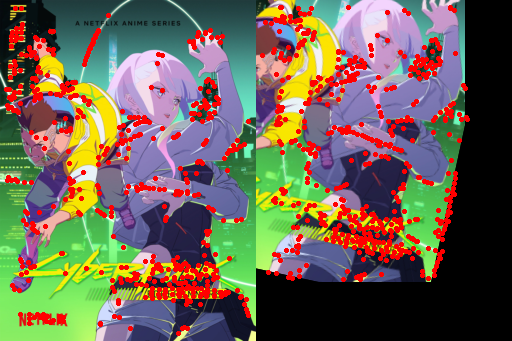

In [4]:
example_image_path = "example.jpg"
image = read_image(example_image_path, ImageReadMode.RGB)

index_image = resize(image)
query_image = transforms(image)
index = KeyPoints.from_images(index_image.unsqueeze(0),batch_size=1)
index_kps_image = utils.visualize_keypoints(index_image, index.pts)

query = KeyPoints.from_images(query_image.unsqueeze(0),batch_size=1)
query_kps_image = utils.visualize_keypoints(query_image, query.pts)

side_by_side = utils.concat(index_kps_image, query_kps_image, dim=1)
side_by_side

In [5]:


tgt_ind, valid = ratio_test_threshold_match(index.desc, query.desc.as_tensor(), 0.75)
src_kpts = index.pts
tgt_kpts = query.pts.gather(dim=-2, index=tgt_ind.unsqueeze(-1).expand_as(query.pts))
pts1 = torch.cat([src_kpts, torch.ones_like(src_kpts[..., [0]])], dim=-1)
pts2 = torch.cat([tgt_kpts, torch.ones_like(tgt_kpts[..., [0]])], dim=-1)
errs, inliners = ransac(pts1, pts2, valid.float(), 0.4, 512)
inliners = inliners & valid

index_pts = src_kpts[inliners]
query_pts = tgt_kpts[inliners]


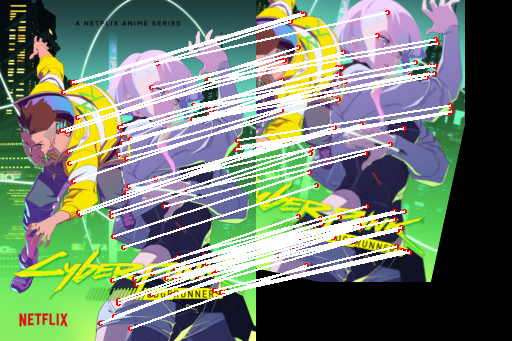

In [6]:


lines_without_ransac = utils.draw_match_lines(
    index_image, query_image, index_pts, query_pts
)
lines_without_ransac

In [7]:
%%capture
!jupyter nbconvert --execute --to markdown README.ipynb